###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2021 Semester 1

## Assignment 1: Pose classification with naive Bayes

###### Submission deadline: 7 pm, Tuesday 6 Apr 2021

**Student ID(s):**     `1090015`  `1086213` 


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

In [33]:
import matplotlib as mpl
import pandas as pd
import numpy as np
import csv
import math
import operator

MISSING_VALUES = '9999'

def preprocess(csvfile):
    '''preprocesses data by reading it from a file into a dataframe, converts string values into float,
    replaces all missing values with NaN'''
    
    with open(csvfile, 'r') as csvfile:
        opened_file = csv.reader(csvfile)

        # excludes rows that have all missing values
        clean_file = exclude_rows(opened_file)
        df_file = pd.DataFrame(clean_file)
    
    # changes str to float
    df_file.iloc[0:, 1:] = df_file.iloc[0:, 1:].astype(float)
    df_file = df_file.replace(9999, np.nan) #replaces 9999 with nan value
    return df_file

def exclude_rows(opened_file):
    '''excludes instances/rows that contain missing values only'''
    
    exclude_file = []
    for columns in opened_file:
        all_999 = False
        for num in columns[1:]:
            if num != MISSING_VALUES: # if missing values
                all_999 = False
                break
            all_999 = True
        if all_999 == False:
            exclude_file.append(columns)
    return exclude_file

train_file = preprocess('train.csv')
test_file = preprocess('test.csv')
train_file
test_file

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,bridge,126.83580,99.92750,NaN,NaN,47.5551,-9.7848,7.377900,-65.1004,-62.3788,...,-14.5613,NaN,NaN,-30.3392,-41.2163,23.3146,57.5625,-24.6930,61.5094,-34.0565
1,bridge,NaN,NaN,NaN,NaN,NaN,NaN,38.160800,-43.0753,-47.0571,...,NaN,NaN,NaN,NaN,NaN,-1.1496,31.4956,-11.7053,-4.8259,-13.8147
2,bridge,135.81920,99.76150,NaN,NaN,48.2256,-14.1838,16.306900,-131.9711,-153.9583,...,-5.0926,NaN,NaN,-38.7297,-48.6293,50.0013,86.1222,-56.0617,NaN,NaN
3,bridge,-95.54230,-42.97660,-31.4373,-50.1283,NaN,NaN,49.972800,NaN,NaN,...,7.6738,-42.7047,-87.5917,NaN,NaN,44.5574,NaN,NaN,41.6346,NaN
4,bridge,NaN,-3.63780,NaN,NaN,16.4145,-12.7766,NaN,NaN,NaN,...,71.5469,NaN,NaN,2.3956,-73.9424,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,warrior2,20.28700,2.47390,-84.6312,-136.0315,82.7249,132.8765,-1.376500,-65.2837,-147.6377,...,67.1076,71.3844,80.3668,70.0619,71.4465,-32.8183,-95.8899,-158.2967,-48.2593,-133.5101
108,warrior2,-4.74110,-10.55660,-47.6025,-27.4689,36.6432,28.6225,-4.816700,-8.7674,-24.8154,...,90.7943,23.4453,-17.9625,34.1370,-9.9678,-9.0408,-63.4394,-66.3922,-60.7615,-61.6052
109,warrior2,-0.92063,-1.78370,-81.5771,-126.4808,79.0495,125.1461,0.072085,-64.7356,-125.9051,...,66.6269,75.5764,83.4368,84.5787,93.6148,-33.3559,-95.1130,-154.8909,-68.1462,-154.8853
110,warrior2,18.07410,4.05720,-83.3156,-135.2014,89.1185,138.1743,1.725100,-74.9515,-143.2362,...,67.1767,68.6667,81.2762,65.7393,68.6013,-32.7961,-87.0205,-142.4231,-57.5704,-144.1459


In [29]:
# This function should calculate prior probabilities and likelihoods from the training data and using
# them to build a naive Bayes model

def train(df):
    '''calculates mean, standard deviation, prior probabilities and likelihood of training data'''
    
    # calculates prior probability P(Cj)
    d_prior = calculate_prior(df.iloc[:,0]) # slices the first column
    
    # calculates mean & sd for each features (columns)
    mean_list = df.groupby([0]).mean().values
    sd_list = df.groupby([0]).std().values
    keys_list = df.groupby([0]).mean().index
    return mean_list, sd_list, d_prior, keys_list

def calculate_prior(series):
    '''calculates prior probability P(Cj)'''
    
    d_prior = {}
    i = 0
    series_value = series.value_counts()
    total = series_value.sum()

    for count in series_value:
        d_prior[series_value.index[i]] = count / total
        i += 1
    return d_prior

mean_list, sd_list, d_prior, keys_list = train(train_file)

In [30]:
# This function should predict classes for new items in a test dataset (for the purposes of this assignment, you
# can re-use the training data as a test set)

def predict(test_file, mean_list, sd_list, d_prior, keys_list):
    '''predicts classes from test_file using naive bayes algorithm'''
    
    prediction = []
    row_idx = 0
    sum_conditional = 0
    for row in test_file.values:
        cond_probability = {}
        row_idx = 0 
        for class_label in keys_list:
            '''sums log likelihood P(x) + sum of P(Xi|Cj) for every instance'''
            sum_conditional = math.log(d_prior[class_label])
            for point_idx in range(len(row)):
                '''sums P(Xi|Cj)'''
                if np.isnan(row[point_idx]):
                    continue # skips missing values
                if (gauss_function(mean_list[row_idx][point_idx], sd_list[row_idx][point_idx], row[point_idx], d_prior[class_label]) == 0):
                    continue # discards those with 0 probabilities
                sum_conditional = sum_conditional + math.log(gauss_function(mean_list[row_idx][point_idx], sd_list[row_idx][point_idx], row[point_idx], d_prior[class_label]))
            row_idx += 1
            cond_probability[class_label] = sum_conditional 
        key_max = max(cond_probability.items(), key = operator.itemgetter(1))[0] # returns dictionary's key that has the highest value 
        prediction.append(key_max)
    return prediction

def gauss_function(mean, sd, x, prior_probability):
    '''calculates P(Xi|Cj) using gaussian distribution's pdf'''
    
    exponent = np.exp(-1/2 * (((x - mean) / sd) ** 2))
    gauss_pdf = exponent / (sd * np.sqrt(2 * np.pi))
    return gauss_pdf


## Questions 


If you are in a group of 1, you will respond to **two** questions of your choosing.

If you are in a group of 2, you will respond to **four** questions of your choosing.

A response to a question should take about 100–250 words, and make reference to the data wherever possible.

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer should be submitted separately as a PDF.

### Q1
Since this is a multiclass classification problem, there are multiple ways to compute precision, recall, and F-score for this classifier. Implement at least two of the methods from the "Model Evaluation" lecture and discuss any differences between them. (The implementation should be your own and should not just call a pre-existing function.)

In [123]:
#### This function should evaluate the prediction performance by comparing your model’s class outputs to ground
# truth labels

def evaluate(test_result, ground_truth):
    '''calculates accuracy, micro & macro precision, recall and f_score'''
    
    # calculates accuracy
    TP = 0
    for i in range(len(test_result)):
        if test_result[i] == ground_truth[i]:
                TP += 1 
    accuracy = TP / len(test_result)
    accuracy = ('accuracy', accuracy)
    
    micro_macro = precision_recall(test_result, ground_truth) # calculates micro & macro precision
    
    return accuracy, micro_macro


def precision_recall(test_result, ground_truth):
    '''this function returns a dictionary of micro & macro precision, recall and f_score'''
    
    TP = FP = FN = TN = F_score = 0
    precision = total_precision = total_recall = 0
    total_TP = total_FP = total_FN = total_F_score = 0
    
    for predicted_result in keys_list:
        for i in range(len(test_result)):
            if test_result[i] == predicted_result and ground_truth[i] == predicted_result: # if actual equals to predicted
                    TP += 1       
            elif test_result[i] != predicted_result and ground_truth[i] == predicted_result:
                    FN += 1 # if actual not equal to predicted and actual is equal to current class, add FP
            elif ground_truth[i] != predicted_result and test_result[i] == predicted_result:
                    FP += 1  # if actual not equal to predicted and predicted is equal to current class, add FN
            elif test_result[i] != predicted_result and ground_truth[i] != predicted_result:
                    TN += 1
        
        total_TP += TP
        total_FP += FP
        total_FN += FN
        
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        F_score = 2 * precision * recall / (precision + recall)
       
        total_precision += precision
        total_recall += recall
        total_F_score += F_score
        
        TP = FP = FN = TN = 0
        
    macro_precision = total_precision / len(set(test_result))
    macro_recall = total_recall / len(set(test_result))
    macro_F_score = total_F_score / len(set(test_result))
    micro_precision = total_TP / (total_TP + total_FP)
    micro_recall = total_TP / (total_TP + total_FN)
    micro_F_score = 2 * micro_precision * micro_recall / (micro_precision + micro_recall)
    
    results_dictionary = {'macro precision': macro_precision, 'macro recall': macro_recall, 'macro F-score': macro_F_score, 'micro precision': micro_precision,
                         'micro recall': micro_recall, 'micro F-score': micro_F_score}
    return results_dictionary

(('accuracy', 0.7946428571428571),
 {'macro precision': 0.7829839020628494,
  'macro recall': 0.7782142857142857,
  'macro F-score': 0.7748490204859374,
  'micro precision': 0.7946428571428571,
  'micro recall': 0.7946428571428571,
  'micro F-score': 0.7946428571428572})

### Q2
The Gaussian naıve Bayes classifier assumes that numeric attributes come from a Gaussian distribution. Is this assumption always true for the numeric attributes in this dataset? Identify some cases where the Gaussian assumption is violated and describe any evidence (or lack thereof) that this has some effect on the classifier’s predictions.

In [124]:
# QQ Plot
from numpy.random import seed
from numpy.random import randn
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
from numpy import mean
from numpy import std
import scipy.stats as stats
import pylab 
import statsmodels.api as sm
import pandas as pd

lower_bound=train_file.quantile(0.05)
upper_bound=train_file.quantile(0.95)
class_label=train_file[0]

#removing the outlier based on the upper and lower bound and replace them with nan
new_feature=train_file.iloc[:,1:][(train_file<upper_bound)&(train_file>lower_bound)]

#train the data set
new_train=pd.concat([class_label, new_feature], axis=1)
mean_list, sd_list, d_prior, keys_list = train(new_train)

#predict the test set based on our new data set
prediction = predict(test_file.iloc[:,1:], mean_list, sd_list, d_prior, keys_list)
accuracy=evaluate(prediction, test_file.iloc[:,0])
print(accuracy)

(('accuracy', 0.7946428571428571), {'macro precision': 0.7829839020628494, 'macro recall': 0.7782142857142857, 'macro F-score': 0.7748490204859374, 'micro precision': 0.7946428571428571, 'micro recall': 0.7946428571428571, 'micro F-score': 0.7946428571428572})


plotting the first 5 attribute of our data


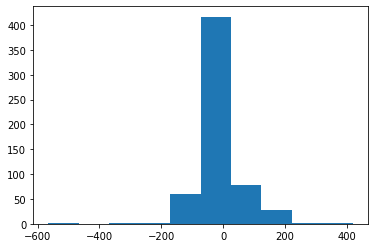

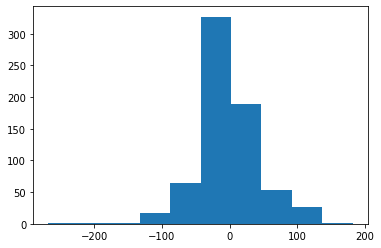

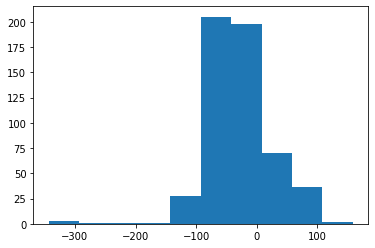

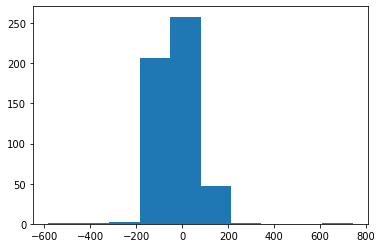

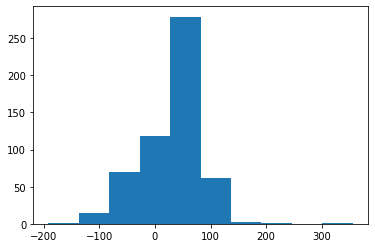

In [125]:
#Plotting just 5 of the raw attribute in histogram
print("plotting the first 5 attribute of our data")
for i in range(1,6):
    pyplot.hist(train_file[i])
    pyplot.show()

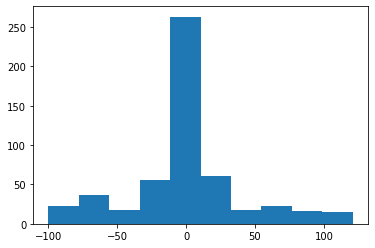

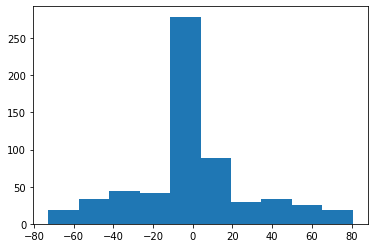

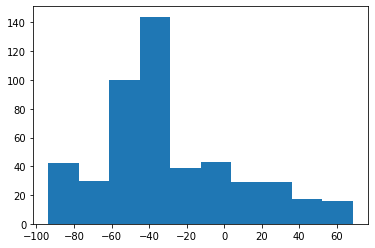

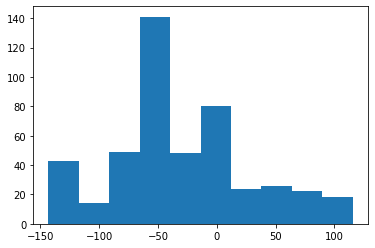

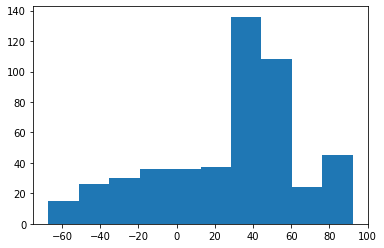

In [118]:
#Plotting just 5 of the new attribute after removing outlier in histogram
for i in range(1,6):   
    pyplot.hist(new_train[i])
    pyplot.show()

### Q3
Implement a kernel density estimate (KDE) naive Bayes classifier and compare its performance to the Gaussian naive Bayes classifier. Recall that KDE has kernel bandwidth as a free parameter -- you can choose an arbitrary value for this, but a value in the range 5-25 is recommended. Discuss any differences you observe between the Gaussian and KDE naive Bayes classifiers. (As with the Gaussian naive Bayes, this KDE naive Bayes implementation should be your own and should not just call a pre-existing function.)

In [126]:
def predict_kde(test_file, d_prior, keys_list, train_file):
    '''predicts test file's class labels based on kernel density estimation'''
    
    prediction = []
    row_idx = 0
    sum_conditional = 0
    bandwith = 5
    
    for row in test_file.values:
        cond_probability = {}
        row_idx = 0
        for class_idx in range(len(keys_list)):
            #sums log likelihood P(x) + sum of P(Xi|Cj) of an instance
            sum_conditional = math.log(d_prior[keys_list[class_idx]])
            for point_idx in range(1, len(row)):
                xi_list = train_file.groupby([0])[point_idx].apply(list) # finds xi list for every features given class label
                xi_list.dropna() # comment this if impute data
                if np.isnan(row[point_idx]):
                    continue # skips missing values
                if (kde_function(xi_list[class_idx], bandwith, row[point_idx], d_prior[keys_list[class_idx]], len(xi_list[class_idx])) == 0):
                    continue # skips 0 probability
                sum_conditional = sum_conditional + math.log(kde_function(xi_list[class_idx], bandwith, row[point_idx], d_prior[keys_list[class_idx]],len(xi_list[class_idx])))
            row_idx += 1

            cond_probability[keys_list[class_idx]] = sum_conditional
        key_max = max(cond_probability.items(), key = operator.itemgetter(1))[0] # returns key of highest probability value
        prediction.append(key_max)
    return prediction

def kde_function(xi_list, sd, x, prior_probability, N):
    '''calculates P(Xi|Cj) using KDE function'''
    
    exponent = 0
    if np.isnan(x):
        return 
    for xi in xi_list: # calculates sum of exponent (x-xi)
        if np.isnan(xi):
            continue
        exponent += np.exp(-1/2 * (((x - xi) / sd) ** 2))
    gauss_pdf = exponent / (N * sd * np.sqrt(2 * np.pi))
    return gauss_pdf

kde_prediction = predict_kde(test_file, d_prior, keys_list, train_file)
kde_prediction
evaluate(kde_prediction, test_file.iloc[:,0])

(('accuracy', 0.7589285714285714),
 {'macro precision': 0.7422037684537685,
  'macro recall': 0.7457539682539682,
  'macro F-score': 0.7339143312827524,
  'micro precision': 0.7589285714285714,
  'micro recall': 0.7589285714285714,
  'micro F-score': 0.7589285714285714})

### Q4
Instead of using an arbitrary kernel bandwidth for the KDE naive Bayes classifier, use random hold-out or cross-validation to choose the kernel bandwidth. Discuss how this changes the model performance compared to using an arbitrary kernel bandwidth.

### Q5
Naive Bayes ignores missing values, but in pose recognition tasks the missing values can be informative. Missing values indicate that some part of the body was obscured and sometimes this is relevant to the pose (e.g., holding one hand behind the back). Are missing values useful for this task? Implement a method that incorporates information about missing values and demonstrate whether it changes the classification results.

In [131]:
def impute_data(df):
    '''imputes NaN to mean of each class label of each feature'''
    
    mean_list = df.groupby([0]).mean().to_dict()
    a = list(df.values)
    for i in range(len(a)):
        class_name = a[i][0]
        k = 1
        for numbers in a[i][1:]:
            if math.isnan(numbers):
                a[i][k] = mean_list[k][class_name]
            k += 1
    b = pd.DataFrame(a)
    return b

train_file = preprocess('train.csv')
train_file2 = impute_data(train_file)
test_file = preprocess('test.csv')
mean_list, sd_list, d_prior, keys_list = train(train_file2)
prediction = predict(test_file.iloc[:,1:], mean_list, sd_list, d_prior, keys_list)
evaluate(prediction, test_file.iloc[:,0])

(('accuracy', 0.7678571428571429),
 {'macro precision': 0.7207738095238095,
  'macro recall': 0.7551984126984126,
  'macro F-score': 0.7264382743693089,
  'micro precision': 0.7678571428571429,
  'micro recall': 0.7678571428571429,
  'micro F-score': 0.7678571428571429})

### Q6
Engineer your own pose features from the provided keypoints. Instead of using the (x,y) positions of keypoints, you might consider the angles of the limbs or body, or the distances between pairs of keypoints. How does a naive Bayes classifier based on your engineered features compare to the classifier using (x,y) values? Please note that we are interested in explainable features for pose recognition, so simply putting the (x,y) values in a neural network or similar to get an arbitrary embedding will not receive full credit for this question. You should be able to explain the rationale behind your proposed features. Also, don't forget the conditional independence assumption of naive Bayes when proposing new features -- a large set of highly-correlated features may not work well.